This kernel is from https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough

# Costa Rican Household Poverty Level Prediction

Welcome to another Kaggle challenge! The objective of the Costa Rican Household Poverty Level Prediction contest is to develop a machine learning model that can predict the poverty level of households using both individual and household characteristics. This "data science for good" project offers the opportunity to put our skills towards a task more beneficial to society than getting people to click on ads!

In this notebook, we will walk through a complete machine learning solution: first, get introduced to the problem, then perform a thorough Exploratory Data Analysis of the dataset, work on feature engineering, try out multiple machine learning models, select a model, work to optimize the model, and finally, inspect the outputs of the model and draw conclusions. __While this notebook may not get us to the top of the leaderboard, it is meant to be used as a teaching tool to give you a solid foundation to build on for future machine learning projects. Kaggle projects can teach us a lot about machine learning, but several of the strategies used to get to the very top of the leaderboard are not best practices, so here we'll stick to building a very good - although not quite first place - machine learning solution. While Kaggle projects are competitions, I think they are best described as "a machine learning education" disguised as a contest!"

If you are looking to follow-up on this work, I have additional work including a kernel on using [Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/featuretools-for-good) with [Featuretools](https://docs.featuretools.com/en/stable/#minute-quick-start) for this problem (with slightly higher leaderboard score). (If you enjoy my writing style and explanations, I write for Towards Data Science)

## Problem and Data Explanation
The data for this competition is provided in two files: train.csv and test.csv. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents **one individual** and each column is a **feature, either unique to the individual, or for the household of the individual**. The training set has one additional column, Target, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of 1 is the most extreme poverty.

This is a **supervised multi-class classification** machine learning problem:

- **Supervised**: provided with the labels for the training data
- **Multi-class classification**: Labels are discrete values with 4 classes

### Objective
The objective is to predict poverty on a **household level**. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we'll have to perform some aggregations of the individual data for each household. Moreover, we have to make a prediction for every individual in the test set, but "ONLY the heads of household are used in scoring" which means we want to predict poverty on a household basis.

**Important note: while all members of a household should have the same label in the training data, there are errors where individuals in the same household have different labels. In these cases, we are told to use the label for the head of each household, which can be identified by the rows where parentesco1 == 1.0**. We will cover how to correct this in the notebook (for more info take a look at the competition main discussion).

The Target values represent poverty levels as follows:

```
1 = extreme poverty 
2 = moderate poverty 
3 = vulnerable households 
4 = non vulnerable households
```

The explanations for all 143 columns can be found in the competition documentation, but a few to note are below:

- **Id**: a unique identifier for each individual, this should not be a feature that we use!
- **idhogar**: a unique identifier for each household. This variable is not a feature, but will be used to group individuals by household as all individuals in a household will have the same identifier.
- **parentesco1**: indicates if this person is the head of the household.
- **Target**: the label, which should be equal for all members in a household
When we make a model, we'll train on a household basis with the label for each household the poverty level of the head of household. The raw data contains a mix of both household and individual characteristics and for the individual data, we will have to find a way to aggregate this for each household. Some of the individuals belong to a household with no head of household which means that unfortunately we can't use this data for training. These issues with the data are completely typical of **real-world** data and hence this problem is great preparation for the datasets you'll encounter in a data science job!

### Metric

Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Our predictions will be assessed by the __Macro F1 Score.__ You may be familiar with the [standard F1 score](http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/) for binary classification problems which is the harmonic mean of precision and recall:

$$F_1 = \frac{2}{\tfrac{1}{\mathrm{recall}} + \tfrac{1}{\mathrm{precision}}} = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

For mutli-class problems, we have to average the F1 scores for each class. The macro F1 score averages the F1 score for each class _without taking into account label imbalances_. 

$$\text{Macro F1} = \frac{\text{F1 Class 1} + \text{F1 Class 2} + \text{F1 Class 3} + \text{F1 Class 4}}{4}$$

In other words, the number of occurrences of each label does not figure into the calculation when using macro (while it does when using the "weighted" score). (For more information on the differences, look at the [Scikit-Learn Documention for F1 Score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) or this [Stack Exchange question and answers](https://datascience.stackexchange.com/q/15989/42908). If we want to assess our performance, we can use the code:

```
from sklearn.metrics import f1_score
f1_score(y_true, y_predicted, average = 'macro`)
```

For this problem, the labels are imbalanced, which makes it a little strange to use macro averaging for the evaluation metric, but that's a decision made by the organizers and not something we can change! In your own work, you want to be aware of label imbalances and choose a metric accordingly. 

## Roadmap

The end objective is a machine learning model that can predict the poverty level of a household. However, before we get carried away with modeling, it's important to understand the problem and data. Also, we want to evaluate numerous models before choosing one as the "best" and after building a model, we want to investigate the predictions. Our roadmap is therefore as follows:

1. Understand the problem (we're almost there already)
2. Exploratory Data Analysis
3. Feature engineering to create a dataset for machine learning
4. Compare several baseline machine learning models
5. Try more complex machine learning models
6. Optimize the selected model
7. Investigate model predictions in context of problem
6. Draw conclusions and lay out next steps 

The steps laid out above are iterative meaning that while we will go through them one at a time, we might go back to an earlier step and revisit some of our decisions. In general, data science is a non-linear pracice where we are constantly evaluating our past decisions and making improvements. In particular, feature engineering, modeling, and optimization are steps that we often repeat because we never know if we got them right the first time!

# Getting Started

We have a pretty good grasp of the problem, so we'll move into the Exploratory Data Analysis (EDA) and feature engineering. For the EDA we'll examine any interesting anomalies, trends, correlations, or patterns that can be used for feature engineering and for modeling. We'll make sure to investigate our data both quantitatively (with statistics) and visually (with figures). 

Once we have a good grasp of the data and any potentially useful relationships, we can do some feature engineering (the most important part of the machine learning pipeline) and establish a baseline model. This won't get us to the top of the leaderboard, but it will provide a strong foundation to build on! 

With all that info in mind (don't worry if you haven't got all the details), let's get started! 

#### Imports
We'll use a familiar stack of data science libraries: Pandas, numpy, matplotlib, seaborn, and eventually sklearn for modeling.

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 12
plt.rcParams['patch.edgecolor'] = 'k'

### Read in Data and Look at Summary information

In [2]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


That gives us a look at all of the columns which don't appear to be in any order. To get a quick overview of the data we use `df.info()`.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


This tells us there are 130 integer columns, 8 float (numeric) columns, and 5 object columns. The integer columns probably represent Boolean variables (that take on either 0 or 1) or [ordinal variables](https://web.ma.utexas.edu/users/mks/statmistakes/ordinal.html) with discrete ordered values. The object columns might pose an issue because they cannot be fed directly into a machine learning model.

Let's glance at the test data which has many more rows (individuals) than the train. It does have one fewer column because there's no Target!

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


#### Integer Columns
Let's look at the distribution of unique values in the integer columns. For each column, we'll count the number of unique values and show the result in a bar plot.

In [5]:
train.select_dtypes(np.int64).nunique()

hacdor             2
rooms             11
hacapo             2
v14a               2
refrig             2
                  ..
SQBhogar_total    13
SQBedjefe         22
SQBhogar_nin      10
agesq             97
Target             4
Length: 130, dtype: int64

In [6]:
train.select_dtypes(np.int64).nunique().value_counts()

2     101
13      5
97      3
22      3
11      3
10      3
9       3
7       3
6       2
4       2
14      1
1       1
dtype: int64

In [7]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index()

1       1
2     101
4       2
6       2
7       3
9       3
10      3
11      3
13      5
14      1
22      3
97      3
dtype: int64

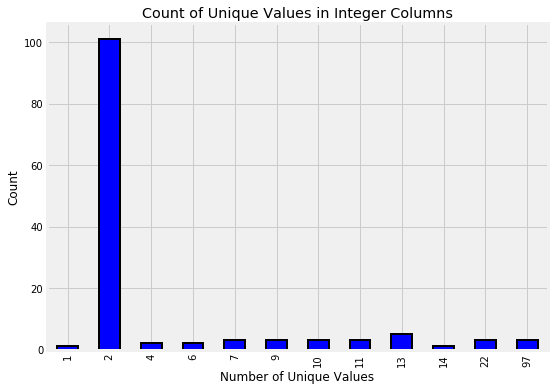

In [8]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='blue',
                                                                            figsize=(8,6),
                                                                             edgecolor='k',
                                                                             linewidth=2)
plt.xlabel('Number of Unique Values'); plt.ylabel('Count')
plt.title('Count of Unique Values in Integer Columns');

The columns with only 2 unique values represent Booleans (0 or 1). In a lot of cases, this boolean information is already on a household level. For example, the `refrig` column says whether or not the household has a refrigerator. When it comes time to make features from the Boolean columns that are on the household level, we will _not need to aggregate_ these. However, the Boolean columns that are on the individual level will need to be aggregated. 

#### Float Columns

Another column type is floats which represent continuous variables. We can make a quick distribution plot to show the distribution of all float columns. We'll use an [`OrderedDict`](https://pymotw.com/2/collections/ordereddict.html) to map the poverty levels to colors because this keeps the keys and values in the same order as we specify (unlike a regular Python dictionary).

The following graphs shows the distributions of the `float` columns colored by the value of the `Target`. With these plots, we can see if there is a significant difference in the variable distribution depending on the household poverty level.

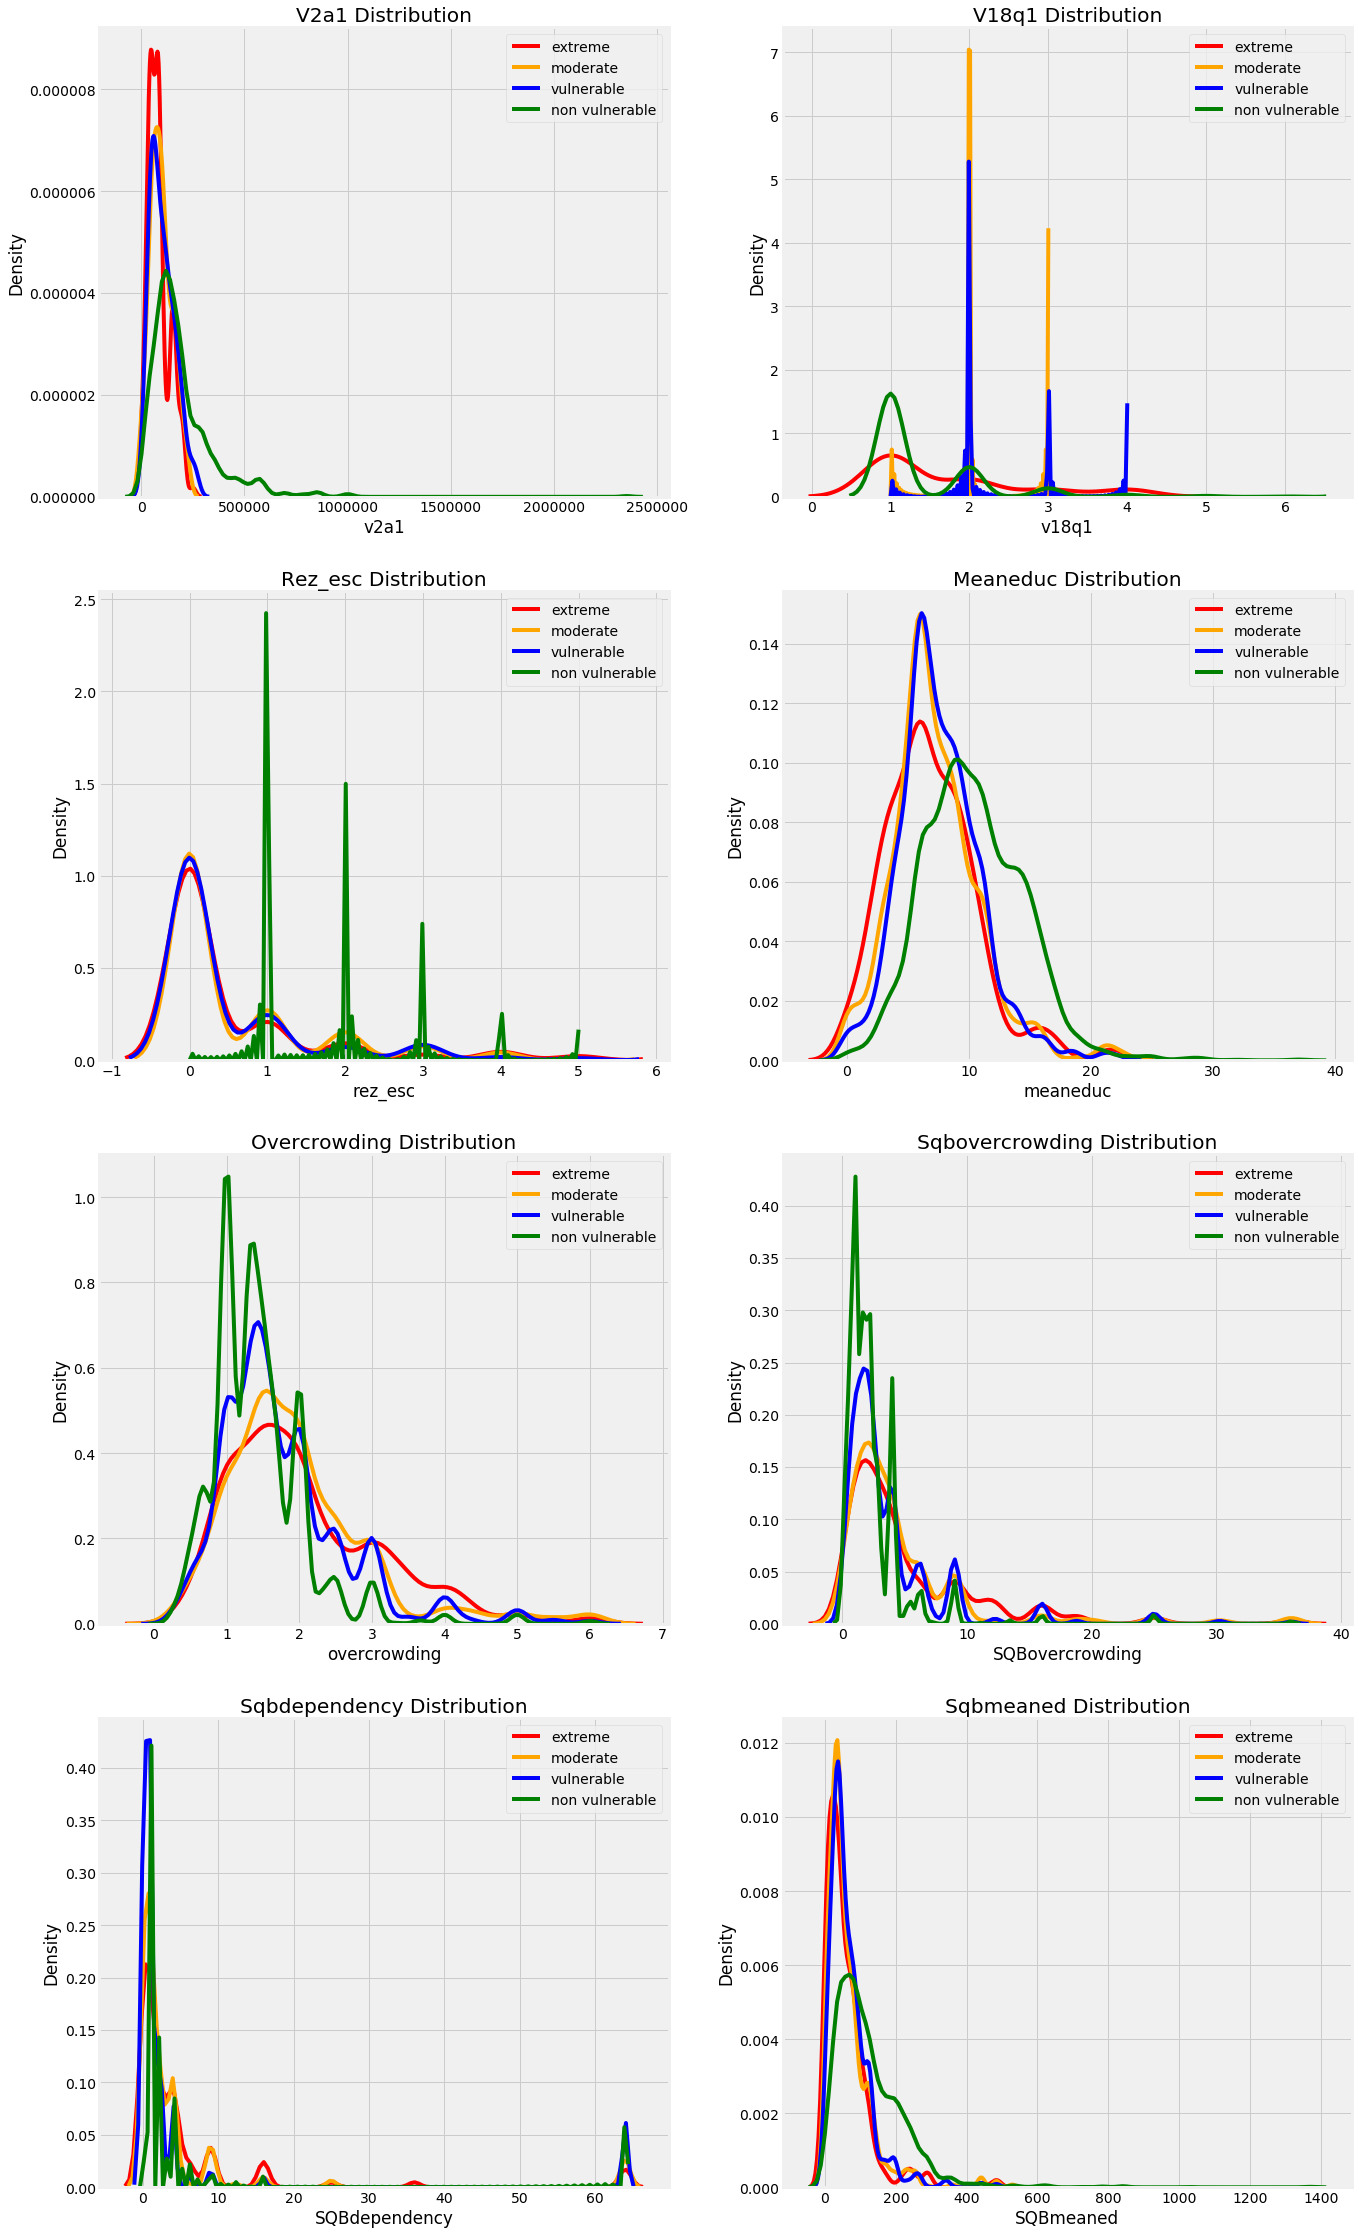

In [9]:
from collections import OrderedDict

plt.figure(figsize=(20,16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2:'moderate', 3:'vulnerable',
                              4: 'non vulnerable'})

# Iterate thorugh the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i+1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target']==poverty_level, col].dropna(),
                   ax=ax, color=color, label=poverty_mapping[poverty_level])
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}'); plt.ylabel('Density')
    
plt.subplots_adjust(top=2)

Later on we'll calculate correlations between the variables and the `Target` to gauge the relationships between the features, but these plots can already give us a sense of which variables may be most "relevant" to a model. For example, the `meaneduc`, representing the average education of the adults in the household appears to be related to the poverty level: __a higher average adult education leads to higher values of the target which are less severe levels of poverty__. The theme of the importance of education is one we will come back to again and again in this notebook! 

#### Object Columns

The last column type is `object` which we can view as follows.

In [10]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


The `Id` and `idhogar` object types make sense because these are identifying variables. However, the other columns seem to be a mix of strings and numbers which we'll need to address before doing any machine learning. According to the documentation for these columns:

* `dependency`: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
* `edjefe`: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* `edjefa`: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

These explanations clear up the issue. For these three variables, __"yes" = 1__ and __"no" = 0__. We can correct the variables using a mapping and convert to floats. 

In [11]:
mapping = {'yes':1, 'no':0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)
    
train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [12]:
train[['dependency', 'edjefe', 'edjefa']].head()

,dependency,edjefe,edjefa
0,0.0,10.0,0.0
1,8.0,12.0,0.0
2,8.0,0.0,11.0
3,1.0,11.0,0.0
4,1.0,11.0,0.0


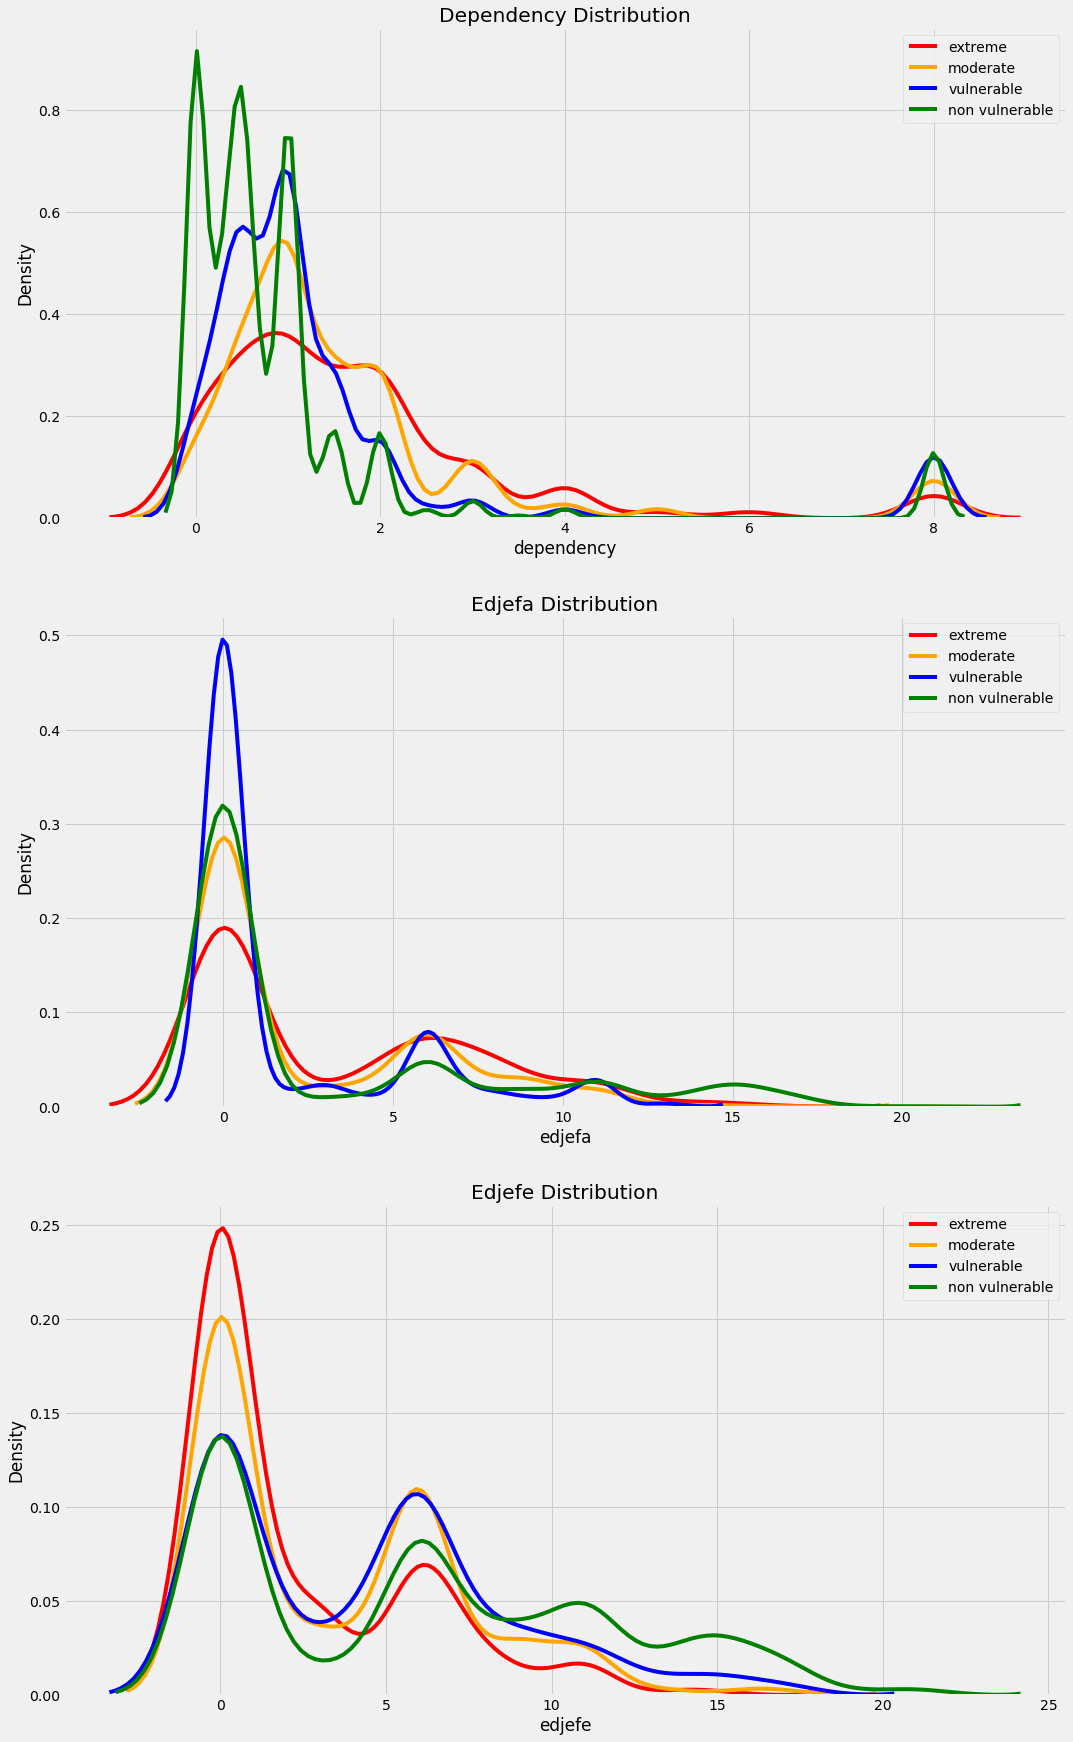

In [13]:
plt.figure(figsize=(16, 12))

# iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i+1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target']==poverty_level, col].dropna(),
                    ax=ax, color=color, label=poverty_mapping[poverty_level])
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}'); plt.ylabel('Density')
plt.subplots_adjust(top=2)

These variables are now correctly represented as numbers and can be fed into a machine learning model. 

To make operations like that above a little easier, we'll join together the training and testing dataframes. This is important once we start feature engineering because we want to apply the same operations to both dataframes so we end up with the same features. Later we can separate out the sets based on the `Target`.

In [14]:
# Add Null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index=True)

## Exploring Label Distribution

Next, we can get an idea of how imbalanced the problem is by looking at the distribution of labels. There are four possible integer levels, indicating four different levels of poverty. To look at the correct labels, we'll subset only to the columns where `parentesco1 == 1` because this is the head of household, the correct label for each household.

The bar plot below shows the distribution of training labels (since there are no testing labels).

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

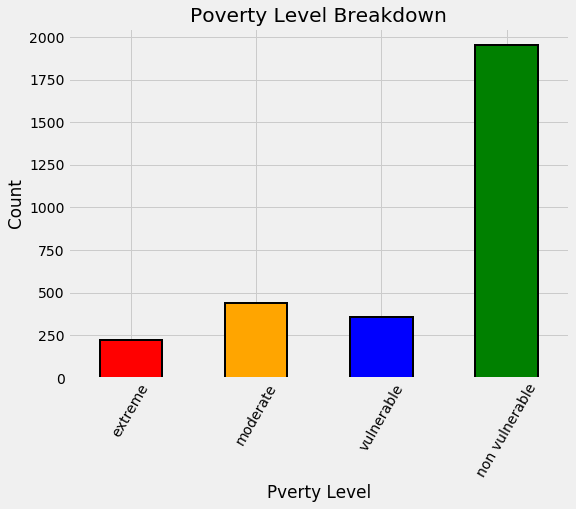

In [15]:
# Heads of household
heads = data.loc[data['parentesco1']==1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1']==1),
                        ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar Plot of occurences of each label
label_counts.plot.bar(figsize=(8,6),
                     color=colors.values(),
                     edgecolor='k',
                     linewidth=2)

# Formatting
plt.xlabel('Pverty Level'); plt.ylabel('Count')
plt.xticks([x-1 for x in poverty_mapping.keys()],
          list(poverty_mapping.values()), rotation=60)
plt.title('Poverty Level Breakdown');

label_counts

In [16]:
colors.values()

odict_values(['red', 'orange', 'blue', 'green'])

In [17]:
poverty_mapping.keys()

odict_keys([1, 2, 3, 4])

In [18]:
poverty_mapping.values()

odict_values(['extreme', 'moderate', 'vulnerable', 'non vulnerable'])

We are dealing with an imbalanced class problem (which makes it intriguing why the contest organizers choose the _macro_ F1 score as the metric instead of _weighted_ F1!). There are many more households that classify as _non vulnerable_ than in any other category. The _extreme_ poverty class is the smallest (I guess this should make us optimistic!).

One problem with imbalanced classification problems is that the machine learning model can have a difficult time predicting the minority classes because it sees far less examples. Think about this in human terms: if we are classifiying poverty and we see far more cases of no poverty than extreme poverty, it will make it more difficult for us to identify the high poverty households because of less exposure. One potential method to address class imbalanceds is through oversampling  (which is covered in more advanced notebooks).

## Addressing Wrong Labels

As with any realistic dataset, the Costa Rican Poverty data has some issues. Typically, 80% of a data science project will be spent cleaning data and fixing anomalies/errors. These can be either human entry errors, measurement errors, or sometimes just extreme values that are correct but stand out. For this problem, some of the labels are not correct because _individuals in the same household have a different poverty level_. We're not told why this may be the case, but we are told to use the head of household as the true label. 

That information makes our job much easier, but in a real-world problem, we would have to figure out the reason _Why_ the labels are wrong and how to address the issue on our own. This section fixes the issue with the labels although it is not strictly necessary: I kept it in the notebook just to show how we may deal with this issue.

### Identify Errors

First we need to find the errors before we can correct them. To find the households with different labels for  family members, we can group the data by the household and then check if there is only one unique value of the `Target`.

In [19]:
# Groupby the household and figure out the number of unique values

all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

In [20]:
all_equal

idhogar
001ff74ca    True
003123ec2    True
004616164    True
004983866    True
005905417    True
             ... 
ff9343a35    True
ff9d5ab17    True
ffae4a097    True
ffe90d46f    True
fff7d6be1    True
Name: Target, Length: 2988, dtype: bool

In [21]:
# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print(f'There are {len(not_equal)} households where the family members do not all have the same target')

There are 85 households where the family members do not all have the same target


Let's look at one example.

In [22]:
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


The organizers tell us that the correct label is that for the head of household, where `parentesco1 == 1`. For this household, the correct label is __3__ for all members. We can correct this (as shown later) by reassigning all the individuals in this household the correct poverty level. In the real-world, you might have to make the tough decision of how to address the problem by yourself (or with the help of your team).

### Families without Heads of Household

We can correct all the label discrepancies by assigning the individuals in the same household the label of the head of household. But wait, you may ask: "What if there are households without a head of household? And what if the members of those households have differing values of the label?" 

Well, since you asked, let's investigate exactly that question! 

In [23]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

households_leader

idhogar
001ff74ca    1
003123ec2    1
004616164    1
004983866    1
005905417    1
            ..
ff9343a35    1
ff9d5ab17    1
ffae4a097    1
ffe90d46f    1
fff7d6be1    1
Name: parentesco1, Length: 2988, dtype: int64

In [24]:
# Find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader==0].index), :]

print(f'There are {households_no_head["idhogar"].nunique()} households without a head')

There are 15 households without a head


In [25]:
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique()==1)
print(f'{sum(households_no_head_equal==False)} Households with no head have different labels')

0 Households with no head have different labels


Well that's a relief! This means that we don't have to worry about a household both where there is no head __AND__ the members have different values of the label! For this problem, according to the organizers, __if a household does not have a head, then there is no true label. Therefore, we actually won't use any of the households without a head for training__ Nonetheless, it's still a good exercise to go through this process of investigating the data! 

### Correct Errors

Now we can correct labels for the households that do have a head __AND__ the members have different poverty levels.

In [26]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


Since we are only going to use the heads of household for the labels, __this step is not completely necessary but it shows a workflow for correcting data errors like you may encounter in real life__. Don't consider it extra work, just practice for your career! 

## Missing Variables

One of the most important steps of exploratory data analysis is finding missing values in the data and determining how to handle them. Missing values have to be filled in before we use a machine learning model and we need to think of the best strategy for filling them in based on the feature: this is where we'll have to start digging into the data definitions.

First we can look at the percentage of missing values in each column.

In [27]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns={0: 'total'})
missing

,total
Id,0
v2a1,24263
hacdor,0
rooms,0
hacapo,0
...,...
SQBovercrowding,0
SQBdependency,0
SQBmeaned,36
agesq,0


In [28]:
# Create a percentage missing
missing['percent'] = missing['total'] / len(data)


missing.sort_values('percent', ascending=False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


We don't have to worry about the `Target` becuase we made that `NaN` for the test data. However, we do need to address the other 3 columns with a high percentage of missing values.

__v18q1__: Number of tablets

Let's start with `v18q1` which indicates the number of tablets owned by a family. We can look at the value counts of this variable. Since this is a household variable, it only makes sense to look at it on a household level, so we'll only select the rows for the head of household.

#### Function to Plot Value Counts

Since we might want to plot value counts for different columns, we can write a simple function that will do it for us!

In [29]:
def plot_value_counts(df, col, heads_only=False):
    """ Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1']==1].copy()
    plt.figure(figsize=(8,6))
    df[col].value_counts().sort_index().plot.bar(color='blue',
                                                edgecolor='k',
                                                linewidth=2)
    plt.xlabel(f'{col}'); plt.ylabel('Count'); plt.title(f'{col} Value Counts');

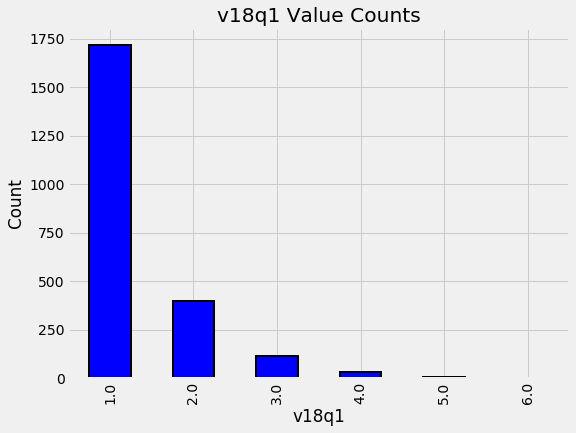

In [30]:
plot_value_counts(heads, 'v18q1')
# heads = data.loc[data['parentesco1']==1].copy()

It looks like the most common number of tablets to own is 1 if we go only by the data that is present. However, we also need to think about the data that is missing. In this case, it could be that families with a `nan` in this category just do not own a tablet! If we look at the data definitions, we see that `v18q` indicates whether or not a family owns a tablet. We should investigate this column combined with the number of tablets to see if our hypothesis holds.

We can `groupby` the value of `v18q` (which is 1 for owns a tablet and 0 for does not) and then calculate the number of null values for `v18q1`. This will tell us if the null values represent that the family does not own a tablet.

In [31]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

Well, that solves the issue! Every family that has `nan` for `v18q1` does not own a tablet. Therefore, we can fill in this missing value with zero.

In [32]:
data['v18q1'] = data['v18q1'].fillna(0)

__v2a1__: Monthly rent payment

The next missing column is `v2a1` which represents the montly rent payment. 

In addition to looking at the missing values of the monthly rent payment, it will be interesting to also look at the distribution of `tipovivi_`, the columns showing the ownership/renting status of the home. For this plot, we show the ownership status of those homes with a `nan` for the monthyl rent payment.

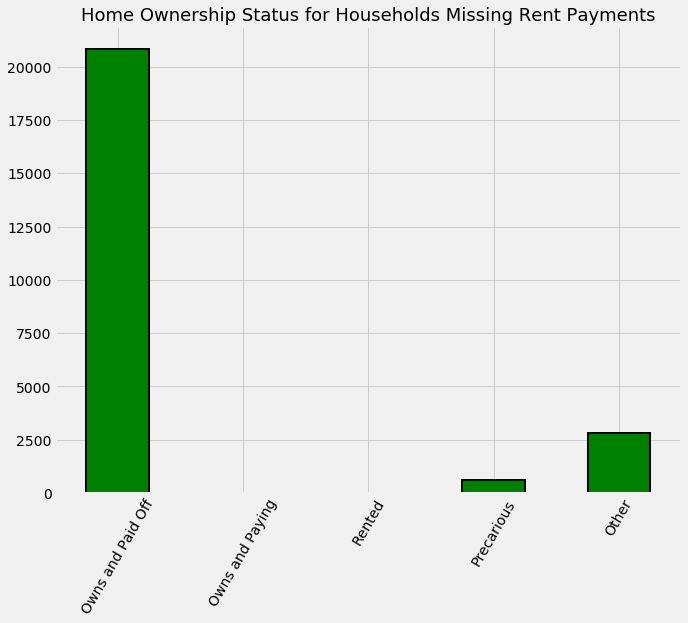

In [33]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]

# plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize=(10,8),
                                                             color='green',
                                                             edgecolor='k',
                                                             linewidth=2)
plt.xticks([0, 1, 2, 3, 4],
          ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', 
          size = 18);

In [34]:
data.loc[data['v2a1'].isnull(), own_variables]

,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5
2,1,0,0,0,0
13,1,0,0,0,0
14,1,0,0,0,0
26,1,0,0,0,0
32,1,0,0,0,0
...,...,...,...,...,...
33408,1,0,0,0,0
33409,1,0,0,0,0
33410,1,0,0,0,0
33411,1,0,0,0,0


In [35]:
data.loc[data['v2a1'].isnull(), own_variables].sum()

tipovivi1    20844
tipovivi2        0
tipovivi3        0
tipovivi4      597
tipovivi5     2822
dtype: int64

The meaning of the home ownership variables is below:

    tipovivi1, =1 own and fully paid house
    tipovivi2, "=1 own,  paying in installments"
    tipovivi3, =1 rented
    tipovivi4, =1 precarious
    tipovivi5, "=1 other(assigned,  borrowed)"
    
We've solved the issue! Well, mostly: the households that do not have a monthly rent payment generally own their own home. In a few other situations, we are not sure of the reason for the missing information. 

For the houses that are owned and have a missing monthly rent payment, we can set the value of the rent payment to zero. For the other homes, we can leave the missing values to be imputed but we'll add a flag (Boolean) column indicating that these households had missing values.

In [36]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1']==1), 'v2a1'] = 0

# Create missing rent paymnet column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

__rez_esc__: years behind in school

The last column with a high percentage of missing values is `rez_esc` indicating years behind in school. For the families with a null value, is possible that they have no children currently in school. Let's test this out by finding the ages of those who have a missing value in this column and the ages of those who do not have a missing value.

In [37]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [38]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

If we read through some of the [discussions for this competition](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403), we learn that this variable is only defined for individuals between 7 and 19. Anyone younger or older than this range presumably has no years behind and therefore the value should be set to 0. 
For this variable, if the individual is over 19 and they have a missing value, or if they are younger than 7 and have a missing value we can set it to zero. For anyone else, we'll leave the value to be imputed and add a boolean flag.

In [39]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

There is also one outlier in the `rez_esc` column. Again, if we read through the competition discussions, we learn that the maximum value for this variable is 5. Therefore, any values above 5 should be set to 5.

In [40]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

## Plot Two Categorical Variables

To show how two categorical variables interact with one another, there are a number of plotting options: scatterplots, faceted bar plots, boxplots, etc. I wasn't satisfied with any of these choices so I wrote the function below, which essentially is a scatterplot of two categoricals where the size of the points represent the percentage of a given y-value represented by each x-value. 

In [41]:
raw_counts = pd.DataFrame(data.groupby('Target')['rez_esc'].value_counts(normalize = False))
raw_counts.head(10)

rez_esc
Target rez_esc         
1.0    0.0          682
       1.0           27
       2.0           12
       4.0            6
       3.0            4
       5.0            3
2.0    0.0         1405
       1.0           64
       2.0           36
       3.0           18

In [42]:
counts = pd.DataFrame(data.groupby('Target')['rez_esc'].value_counts(normalize = True))
counts.head(10)

rez_esc
Target rez_esc          
1.0    0.0      0.929155
       1.0      0.036785
       2.0      0.016349
       4.0      0.008174
       3.0      0.005450
       5.0      0.004087
2.0    0.0      0.915906
       1.0      0.041721
       2.0      0.023468
       3.0      0.011734

In [43]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

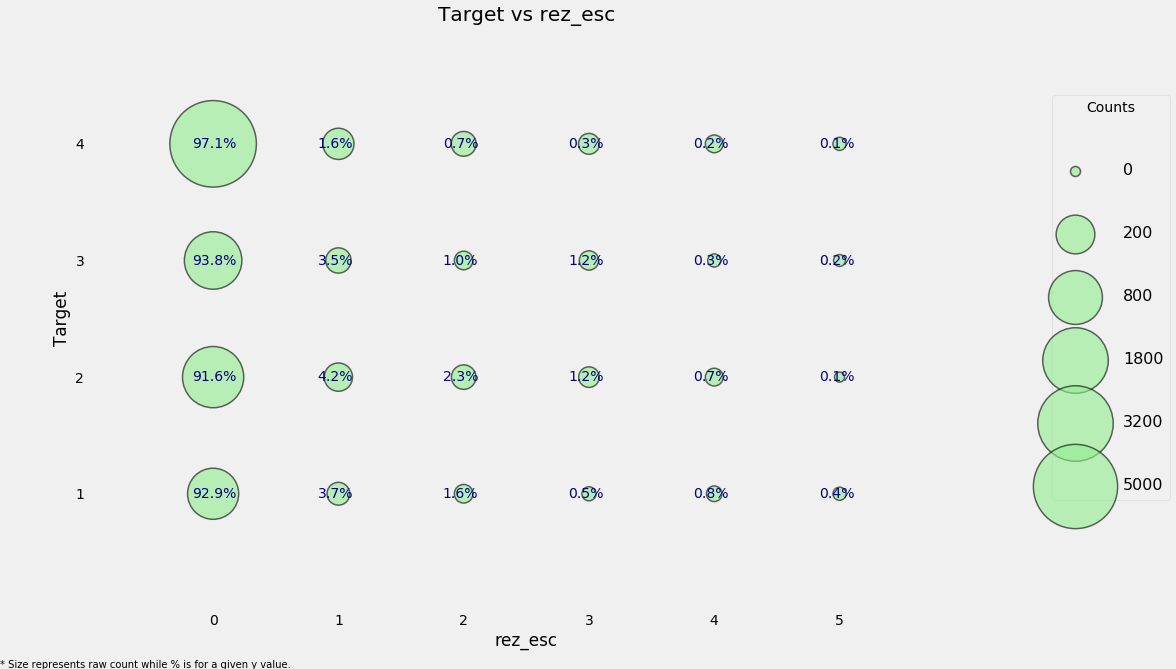

In [44]:
plot_categoricals('rez_esc', 'Target', data);

The size of the markers represents the raw count. To read the plot, choose a given y-value and then read across the row. For example, with a poverty level of 1, 93% of individuals have no years behind with a total count of around 800 individuals and about 0.4% of individuals are 5 years behind with about 50 total individuals in this category. This plot attempts to show both the overall counts and the within category proportion; it's not perfect , but I gave it a shot!

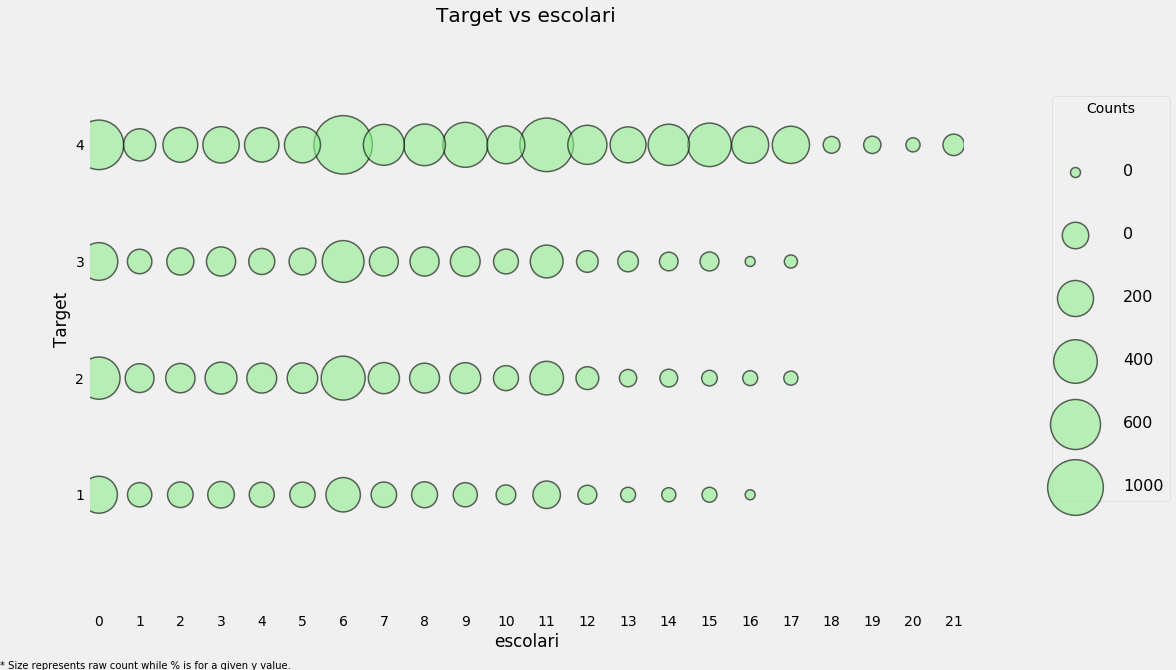

In [45]:
plot_categoricals('escolari', 'Target', data, annotate = False)

The remaining missing values in each column will be filled in, a process known as `Imputation`. There are several types of imputation commonly used, and one of the simplest and most effective methods is to fill in the missing values with the `median` of the column.

As a final step with the missing values, we can plot the distribution of target for the case where either of these values are missing. 

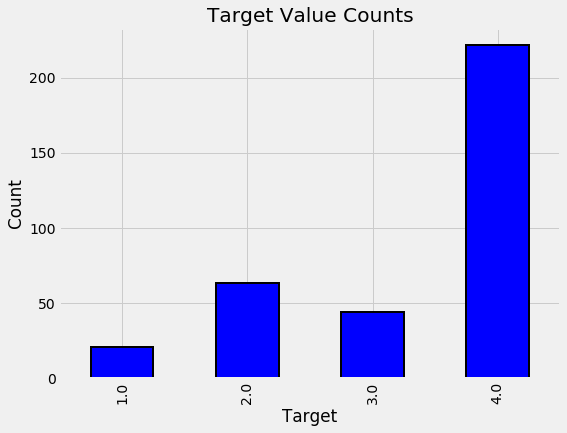

In [46]:
plot_value_counts(data[(data['rez_esc-missing']==1)], 'Target');

The distribution here seems to match that for all the data at large.

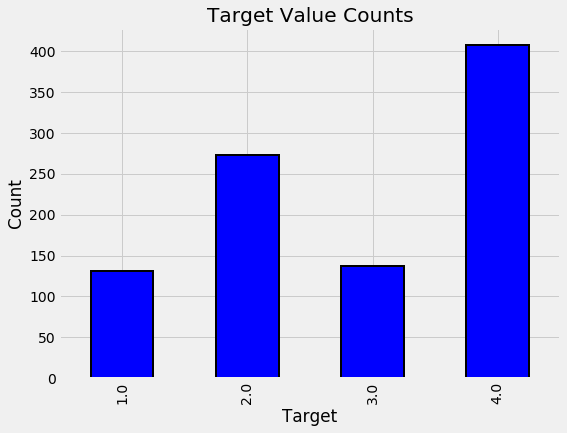

In [47]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 'Target')

This looks like it could be an indicator of more poverty given the higher prevalence of 2: moderate poverty. 

__This represents an important point__: sometimes the missing information is just as important as the information you are given. 

# Feature Engineering

There is plenty more exploratory data analysis we can do, but first we should work on consolidating our data at a household level. We already have some of the information for each household, but for training, we will need _all_ of the information summarized for each household. This means grouping the individuals in a house (`groupby`) and performing an aggregation (`agg`) of the individual variables. 

In another notebook, I show how we can use automated feature engineering to do this, and __automated feature engineering__ should be a standard part of the machine learning workflow. Right now, we'll stick to doing this by hand, but definitely take a look at __automated feature engineering in Featuretools__.

## Column Definitions

Sometimes in data science we have to get our hands dirty digging through the data or do tedious tasks that take a lot of time. This is that part of the analysis: we have to define the columns that are at an individual level and at a household level using the [data decsriptions](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data). There is simply no other way to identify which variables at are the household level than to go through the variables themselves in the data description. Except, I've already done this for you, so all you have to do is copy and paste!

We'll define different variables because we need to treat some of them in a different manner. Once we have the variables defined on each level, we can work to start aggregating them as needed.

The process is as follows

1. Break variables into household level and invididual level
2. Find suitable aggregations for the individual level data
    * Ordinal variables can use statistical aggregations
    * Boolean variables can also be aggregated but with fewer stats
3. Join the individual aggregations to the household level data

### Define Variable Categories

There are several different categories of variables:

1. Individual Variables: these are characteristics of each individual rather than the household
    * Boolean: Yes or No (0 or 1)
    * Ordered Discrete: Integers with an ordering
2. Household variables
    * Boolean: Yes or No
    * Ordered Discrete: Integers with an ordering
    * Continuous numeric
3. Squared Variables: derived from squaring variables in the data
4. Id variables: identifies the data and should not be used as features

Below we manually define the variables in each category. This is a little tedious, but also necessary. 

In [48]:
id_ = ['Id', 'idhogar', 'Target']

In [49]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [50]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [51]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

In [52]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

In [53]:
print('There rare no repeats: ', np.all(np.array(list(Counter(x).values()))==1))

There rare no repeats:  True


In [54]:
print('We covered every variable: ', len(x)==data.shape[1])

We covered every variable:  True


#### Squared Variables

First, the easiest step: we'll remove all of the squared variables. Sometimes variables are squared or transformed as part of feature engineering because it can help linear models learn relationships that are non-linear. However, since we will be using more complex models, these squared features are redundant. They are highly correlated with the non-squared version, and hence can actually hurt our model by adding irrelevant information and also slowing down training.

For an example, let's take a look at `SQBage` vs `age`.

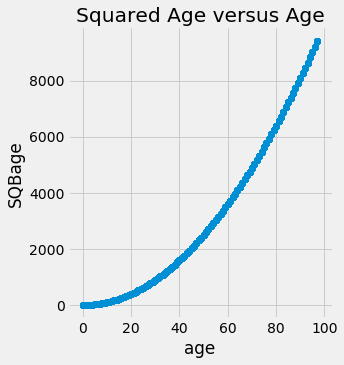

In [55]:
sns.lmplot('age', 'SQBage', data = data, fit_reg=False);
plt.title('Squared Age versus Age');

These variables are highly correlated, and we don't need to keep both in our data.

In [56]:
# Remove squared variables
data = data.drop(columns = sqr_)
data.shape

(33413, 136)

## Id Variables

These are pretty simple: they will be kept as is in the data since we need them for identification.

## Household Level Variables

First let's subset to the heads of household and then to the household level variables.

In [57]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

For most of the household level variables, we can simply keep them as is: since we want to make predictions for each household, we use these variables as features. However, we can also remove some redundant variables and also add in some more features derived from existing data. 

### Redundant Household Variables

Let's take a look at the correlations between all of the household variables. If there are any that are too highly correlated, then we might want to remove one of the pair of highly correlated variables.

The following code identifies any variables with a greater than 0.95 absolute magnitude correlation.

In [58]:
# Create correlation matix
corr_matrix = heads.corr()

corr_matrix

,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,v18q1,tamhog,tamviv,hhsize,hogar_nin,hogar_adul,hogar_mayor,hogar_total,bedrooms,qmobilephone
Target,1.000000,-0.136275,-0.096313,0.068230,0.119607,0.254469,-0.078851,-0.104545,-0.209131,-0.096893,-0.152979,-0.040128,-0.039861,0.005231,0.275452,0.016832,-0.054463,-0.114144,-0.103487,0.014357,0.032872,-0.026240,0.031516,0.295249,0.062961,-0.046518,-0.055818,0.021908,-0.009437,-0.051036,-0.007696,-0.049932,0.097592,-0.062316,-0.083835,-0.017669,-0.054739,0.158804,-0.083063,-0.162796,0.156930,-0.060286,-0.142433,-0.041221,NaN,0.023812,-0.208170,-0.162652,0.280947,-0.209181,-0.128644,0.261142,-0.217908,-0.174310,0.293540,-0.022316,0.131069,0.032834,-0.109057,-0.095326,0.173324,0.137407,0.175124,-0.019746,-0.085646,-0.084516,-0.079679,-0.047958,0.089509,-0.089509,-0.133152,0.161353,-0.126465,0.235687,0.052310,0.333652,-0.234954,0.201019,-0.186530,0.086395,-0.023307,-0.209479,-0.038193,-0.142157,-0.260917,0.036476,-0.111489,0.197493,-0.111557,-0.122554,-0.111557,-0.266309,0.127904,-0.025173,-0.111557,0.135203,0.168685
hacdor,-0.136275,1.000000,0.593867,-0.086701,-0.066409,-0.113787,0.026165,0.019816,0.110713,0.122610,0.068846,0.086632,-0.007015,-0.005960,-0.143259,-0.005960,0.026892,0.116650,0.026372,-0.036627,-0.007641,-0.008595,-0.006613,-0.148678,-0.036094,0.036627,0.005125,-0.004565,-0.003695,-0.002945,0.006355,0.064991,0.006987,-0.030309,0.053491,-0.007932,-0.012058,-0.035395,0.023407,0.033674,-0.060450,0.029765,0.051689,0.007229,-0.001652,-0.006817,0.146991,0.037738,-0.127219,0.112619,0.047893,-0.119760,0.151133,0.059861,-0.148503,-0.083256,-0.043135,0.046399,0.121261,0.072329,-0.054428,-0.041849,-0.054110,0.009782,0.027159,-0.008010,0.037814,0.030319,-0.009123,0.009123,0.116965,-0.019910,0.019191,-0.047917,-0.027628,-0.092837,0.620093,-0.197812,0.243406,0.050627,0.175272,0.219364,0.095605,0.191594,0.302703,0.099775,0.246122,-0.054685,0.246793,0.297433,0.246793,0.295757,0.043431,-0.058321,0.246793,-0.189177,0.026514
hacapo,-0.096313,0.593867,1.000000,-0.123276,-0.075336,-0.094350,0.022254,0.007634,0.089127,0.134901,0.042265,0.118369,-0.005219,-0.004434,-0.120922,-0.004434,-0.002458,0.115475,0.023931,-0.047382,-0.007023,-0.006394,-0.004920,-0.131246,-0.038001,0.035262,0.013710,-0.022503,-0.002749,0.002857,0.023222,0.105027,-0.013006,-0.027034,0.089556,-0.005901,0.002071,-0.028908,0.011194,0.042592,-0.056761,0.030683,0.045590,0.013695,-0.001229,-0.005071,0.133999,0.011774,-0.094734,0.112630,0.018830,-0.092966,0.153102,0.031874,-0.124185,-0.061334,-0.038374,0.030007,0.122973,0.050853,-0.039341,-0.035871,-0.055738,0.009390,0.029604,-0.005307,0.026064,0.041579,-0.012488,0.012488,0.097741,-0.019566,0.011497,-0.039651,-0.026451,-0.088360,0.467570,-0.200073,0.188811,0.056090,0.150316,0.170801,0.063220,0.140345,0.235222,0.082186,0.194963,-0.047469,0.195462,0.252206,0.195462,0.223288,0.046811,-0.043296,0.195462,-0.126525,0.036755
v14a,0.068230,-0.086701,-0.123276,1.000000,0.145417,0.065795,0.002527,0.007668,-0.020410,-0.128082,-0.068496,-0.034484,0.003483,0.002960,0.094633,0.002960,-0.057915,-0.140181,-0.076321,0.047145,0.012098,0.004268,0.003284,0.087430,0.169428,-0.110830,-0.178016,0.034658,0.001835,-0.096564,-0.000137,-0.460629,0.022767,0.082497,-0.135782,0.0

In [59]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,v18q1,tamhog,tamviv,hhsize,hogar_nin,hogar_adul,hogar_mayor,hogar_total,bedrooms,qmobilephone
Target,NaN,-0.136275,-0.096313,0.068230,0.119607,0.254469,-0.078851,-0.104545,-0.209131,-0.096893,-0.152979,-0.040128,-0.039861,0.005231,0.275452,0.016832,-0.054463,-0.114144,-0.103487,0.014357,0.032872,-0.026240,0.031516,0.295249,0.062961,-0.046518,-0.055818,0.021908,-0.009437,-0.051036,-0.007696,-0.049932,0.097592,-0.062316,-0.083835,-0.017669,-0.054739,0.158804,-0.083063,-0.162796,0.156930,-0.060286,-0.142433,-0.041221,NaN,0.023812,-0.208170,-0.162652,0.280947,-0.209181,-0.128644,0.261142,-0.217908,-0.174310,0.293540,-0.022316,0.131069,0.032834,-0.109057,-0.095326,0.173324,0.137407,0.175124,-0.019746,-0.085646,-0.084516,-0.079679,-0.047958,0.089509,-0.089509,-0.133152,0.161353,-0.126465,0.235687,0.052310,0.333652,-0.234954,0.201019,-0.186530,0.086395,-0.023307,-0.209479,-0.038193,-0.142157,-0.260917,0.036476,-0.111489,0.197493,-0.111557,-0.122554,-0.111557,-0.266309,0.127904,-0.025173,-0.111557,0.135203,0.168685
hacdor,NaN,NaN,0.593867,-0.086701,-0.066409,-0.113787,0.026165,0.019816,0.110713,0.122610,0.068846,0.086632,-0.007015,-0.005960,-0.143259,-0.005960,0.026892,0.116650,0.026372,-0.036627,-0.007641,-0.008595,-0.006613,-0.148678,-0.036094,0.036627,0.005125,-0.004565,-0.003695,-0.002945,0.006355,0.064991,0.006987,-0.030309,0.053491,-0.007932,-0.012058,-0.035395,0.023407,0.033674,-0.060450,0.029765,0.051689,0.007229,-0.001652,-0.006817,0.146991,0.037738,-0.127219,0.112619,0.047893,-0.119760,0.151133,0.059861,-0.148503,-0.083256,-0.043135,0.046399,0.121261,0.072329,-0.054428,-0.041849,-0.054110,0.009782,0.027159,-0.008010,0.037814,0.030319,-0.009123,0.009123,0.116965,-0.019910,0.019191,-0.047917,-0.027628,-0.092837,0.620093,-0.197812,0.243406,0.050627,0.175272,0.219364,0.095605,0.191594,0.302703,0.099775,0.246122,-0.054685,0.246793,0.297433,0.246793,0.295757,0.043431,-0.058321,0.246793,-0.189177,0.026514
hacapo,NaN,NaN,NaN,-0.123276,-0.075336,-0.094350,0.022254,0.007634,0.089127,0.134901,0.042265,0.118369,-0.005219,-0.004434,-0.120922,-0.004434,-0.002458,0.115475,0.023931,-0.047382,-0.007023,-0.006394,-0.004920,-0.131246,-0.038001,0.035262,0.013710,-0.022503,-0.002749,0.002857,0.023222,0.105027,-0.013006,-0.027034,0.089556,-0.005901,0.002071,-0.028908,0.011194,0.042592,-0.056761,0.030683,0.045590,0.013695,-0.001229,-0.005071,0.133999,0.011774,-0.094734,0.112630,0.018830,-0.092966,0.153102,0.031874,-0.124185,-0.061334,-0.038374,0.030007,0.122973,0.050853,-0.039341,-0.035871,-0.055738,0.009390,0.029604,-0.005307,0.026064,0.041579,-0.012488,0.012488,0.097741,-0.019566,0.011497,-0.039651,-0.026451,-0.088360,0.467570,-0.200073,0.188811,0.056090,0.150316,0.170801,0.063220,0.140345,0.235222,0.082186,0.194963,-0.047469,0.195462,0.252206,0.195462,0.223288,0.046811,-0.043296,0.195462,-0.126525,0.036755
v14a,NaN,NaN,NaN,NaN,0.145417,0.065795,0.002527,0.007668,-0.020410,-0.128082,-0.068496,-0.034484,0.003483,0.002960,0.094633,0.002960,-0.057915,-0.140181,-0.076321,0.047145,0.012098,0.004268,0.003284,0.087430,0.169428,-0.110830,-0.178016,0.034658,0.001835,-0.096564,-0.000137,-0.460629,0.022767,0.082497,-0.135782,0.003939,-0.125215,0.037976,0.000772,-0.050813,0.068897,-

In [60]:
np.triu(np.ones(corr_matrix.shape), k=1)

array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [61]:
np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

In [62]:
# Find index of featrue columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

These show one out of each pair of correlated variables. To find the other pair, we can subset the `corr_matrix`. 

In [63]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


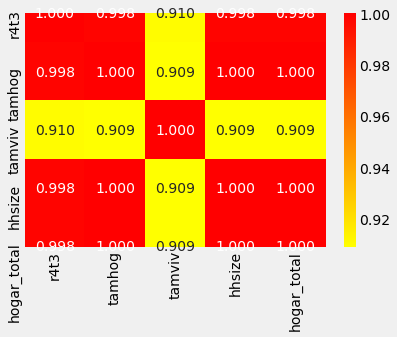

In [64]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
           annot=True, cmap=plt.cm.autumn_r, fmt='.3f');

There are several variables here having to do with the size of the house:

* r4t3, Total persons in the household
* tamhog, size of the household
* tamviv, number of persons living in the household
* hhsize, household size
* hogar_total, # of total individuals in the household

These variables are all highly correlated with one another. In fact, `hhsize` has a perfect correlation with `tamhog` and `hogar_total`. We will remove these two variables because the information is redundant. We can also remove `r4t3` because it has a near perfect correlation with `hhsize`.

`tamviv` is not necessarily the same as `hhsize` because there might be family members that are not living in the household. Let's visualize this difference in a scatterplot.

In [65]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

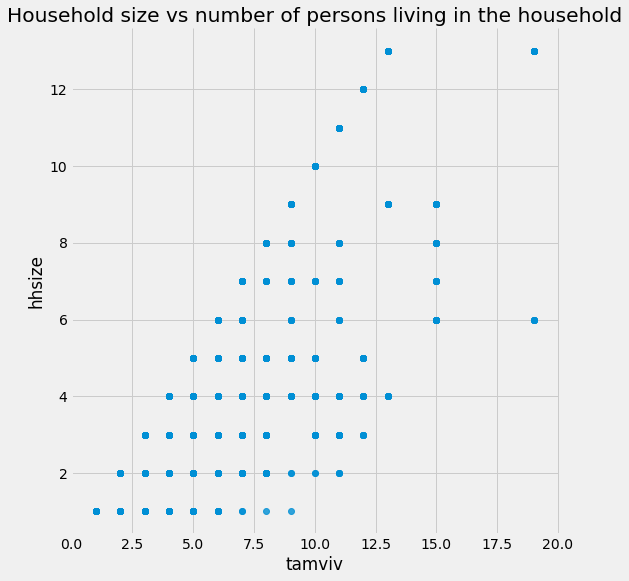

In [66]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, height = 8);
plt.title('Household size vs number of persons living in the household');

We see for a number of cases, there are more people living in the household than there are in the family. This gives us a good idea for a new feature: __the difference between these two measurements!__

Let's make this new feature.

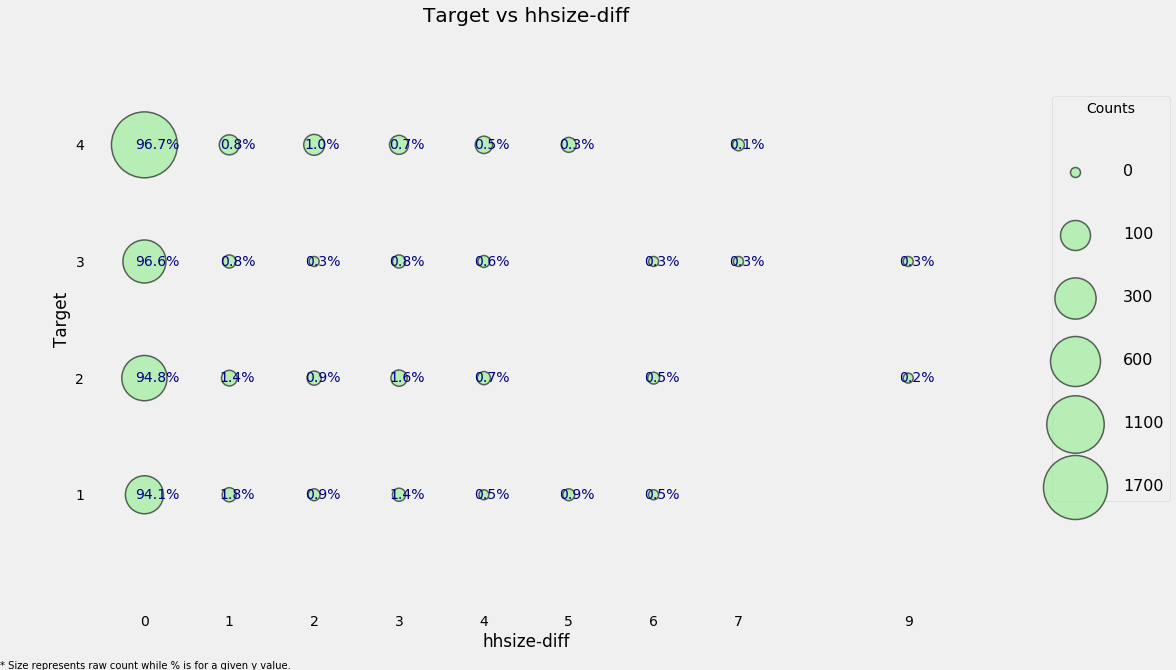

In [67]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

Even though most households do not have a difference, there are a few that have more people living in the household than are members of the household.

Let's move on to the other redundant variables. First we can look at `coopele`

In [68]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


These variables indicate where the electricity in the home is coming from. There are four options, and the families that don't have one of these two options either have no electricity (`noelec`) or get it from a private plant (`planpri`). 

#### Creating Ordinal Variable

I'm going to compress these four variables into one by creating an ordinal variable. I'm going to choose the mapping myself, based on the data decriptions: 

    0: No electricity
    1: Electricity from cooperative
    2: Electricity from CNFL, ICA, ESPH/JASEC
    3: Electricity from private plant

An ordered variable has an inherent ordering, and for this we choose our own based on the domain knowledge. After we create this new ordered variable, we can drop the four others. There are several households that do not have a variable here, so we will use a `nan` (which will be filled in during imputation) and add a Boolean column indicating there was no measure for this variable.

In [69]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

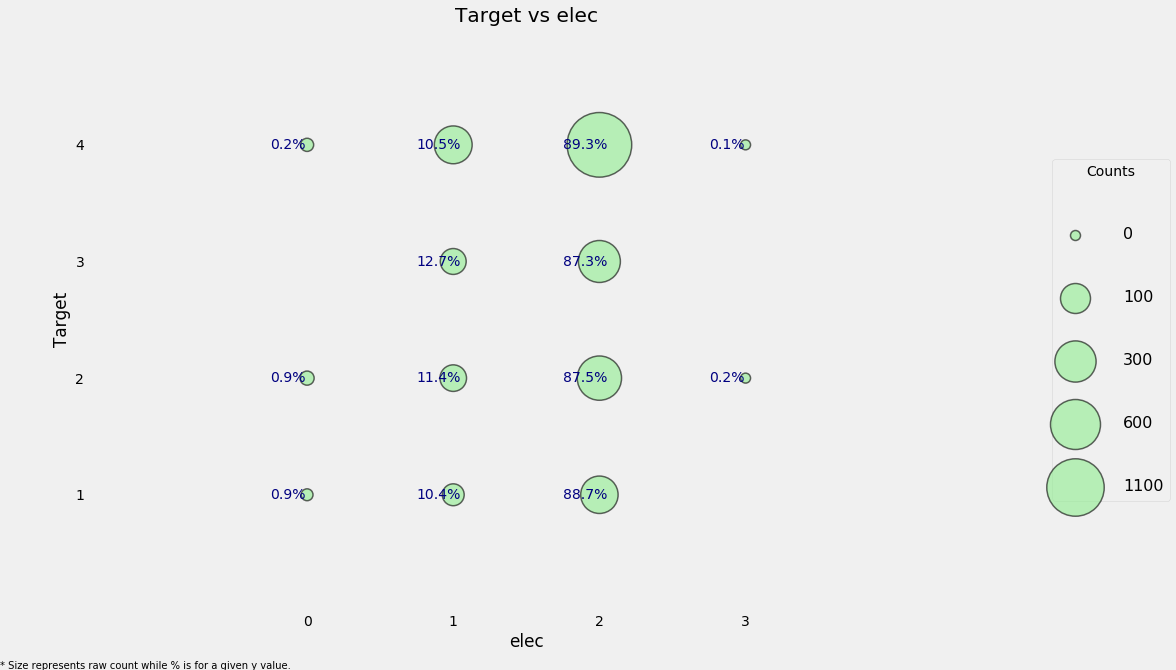

In [70]:
plot_categoricals('elec', 'Target', heads)

We can see that for every value of the Target, the most common source of electricity is from one of the listed providers. 

The final redundant column is `area2`. This means the house is in a rural zone, but it's redundant because we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.

In [71]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize=True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

It seems like households in an urban area (value of 1) are more likely to have lower poverty levels than households in a rural area (value of 0).

### Creating Ordinal Variables

For the walls, roof, and floor of the house, there are three columns each: the first indicating 'bad', the second 'regular', and the third 'good'. We could leave the variables as booleans, but to me it makes more sense to turn them into ordinal variables because there is an inherent order: `bad < regular < good`. To do this, we can simply find whichever column is non-zero for each household using `np.argmax`. 

Once we have created the ordinal variable, we are able to drop the original variables.

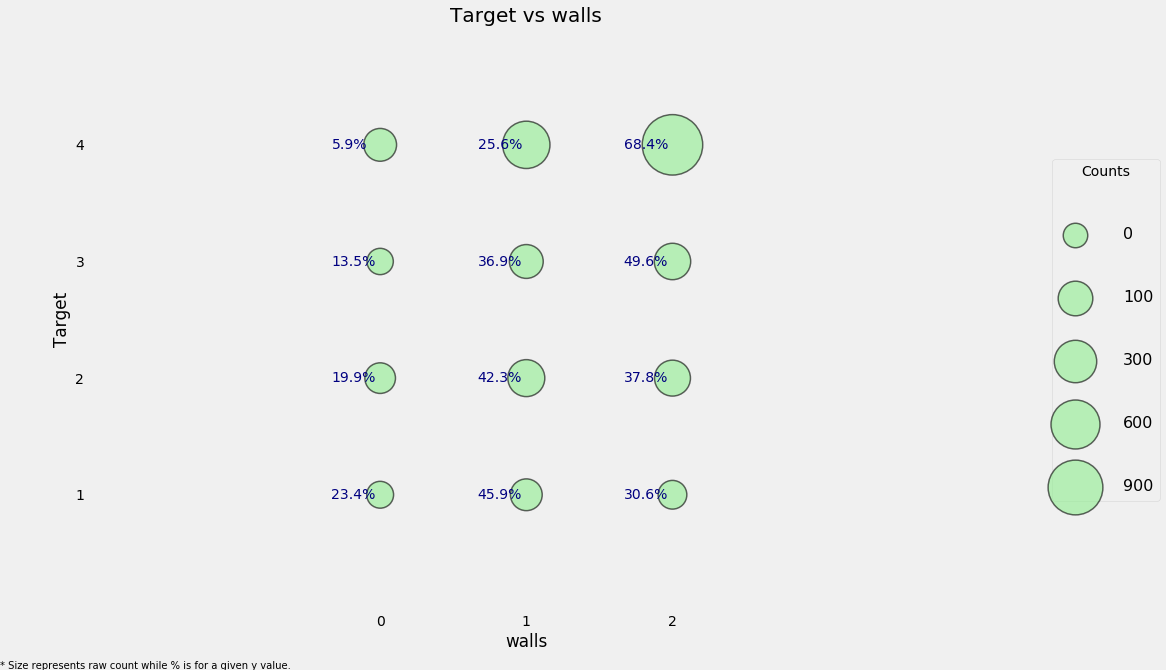

In [72]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                          axis=1)

heads = heads.drop(columns=['epared1', 'epared2', 'epared3'])

plot_categoricals('walls', 'Target', heads)

In [73]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                         axis=1)
heads = heads.drop(columns=['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1' ,'eviv2', 'eviv3']]),
                          axis=1)
heads = heads.drop(columns=['eviv1', 'eviv2', 'eviv3'])

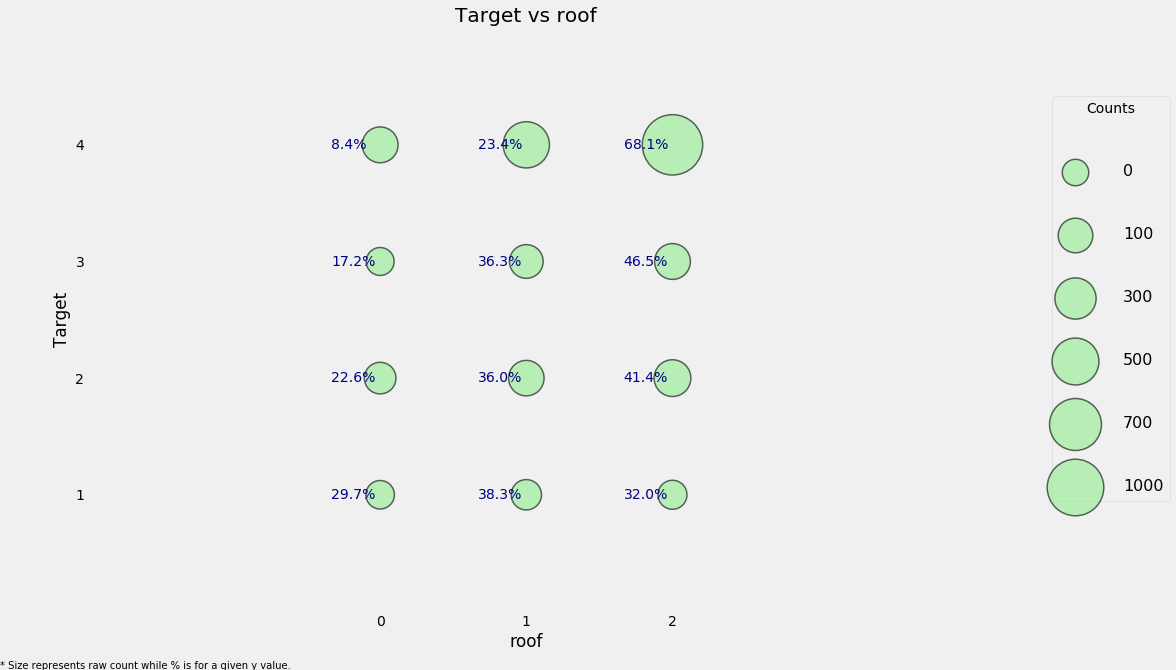

In [74]:
plot_categoricals('roof', 'Target', heads)

## Feature Construction

In addition to mapping variables to ordinal features, we can also create entirely new features from the existing data, known as feature construction. For example, we can add up the previous three features we just created to get an overall measure of the quality of the house's structure.

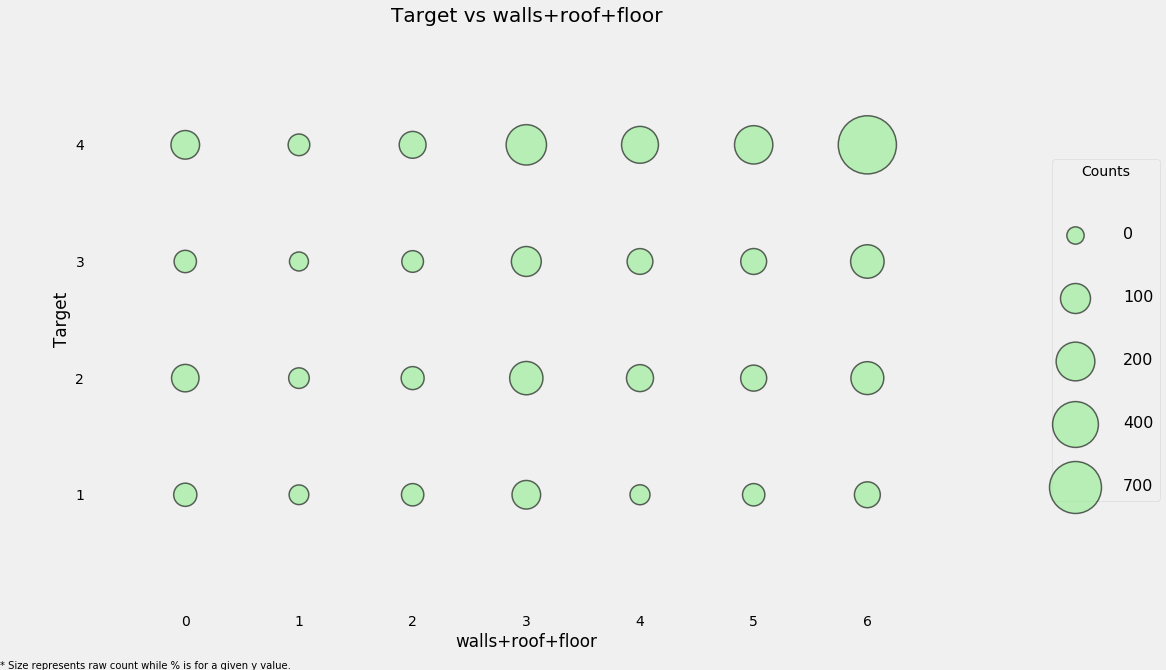

In [75]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

plot_categoricals('walls+roof+floor', 'Target', heads, annotate=False)

This new feature may be useful because it seems like a Target of 4 (the lowest poverty level) tends to have higher values of the 'house quality' variable. We can also look at this in a table to get the fine-grained details.

In [76]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize=True)).rename(columns={'Target': 'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


The next variable will be a `warning` about the quality of the house. It will be a negative value, with -1 point each for no toilet, electricity, floor, water service, and ceiling.

In [77]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] +
                       (heads['elec'] == 0) +
                       heads['pisonotiene'] +
                       heads['abastaguano'] +
                       (heads['cielorazo'] == 0))

We can keep using our `plot_categoricals` function to visualize these relationships, but `seaborn` also has a number of plotting options that can work with categoricals. One is the `violinplot` which shows the distribution of a variable on the y axis with the width of each plot showing the number of observations in that category. 

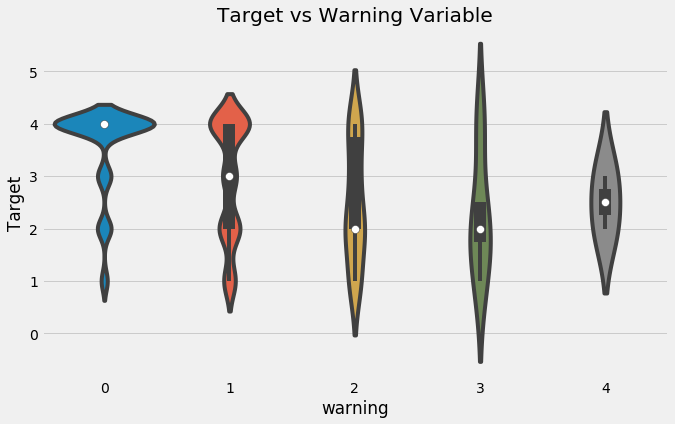

In [78]:
plt.figure(figsize=(10,6))
sns.violinplot(x='warning', y='Target', data=heads);
plt.title('Target vs Warning Variable');

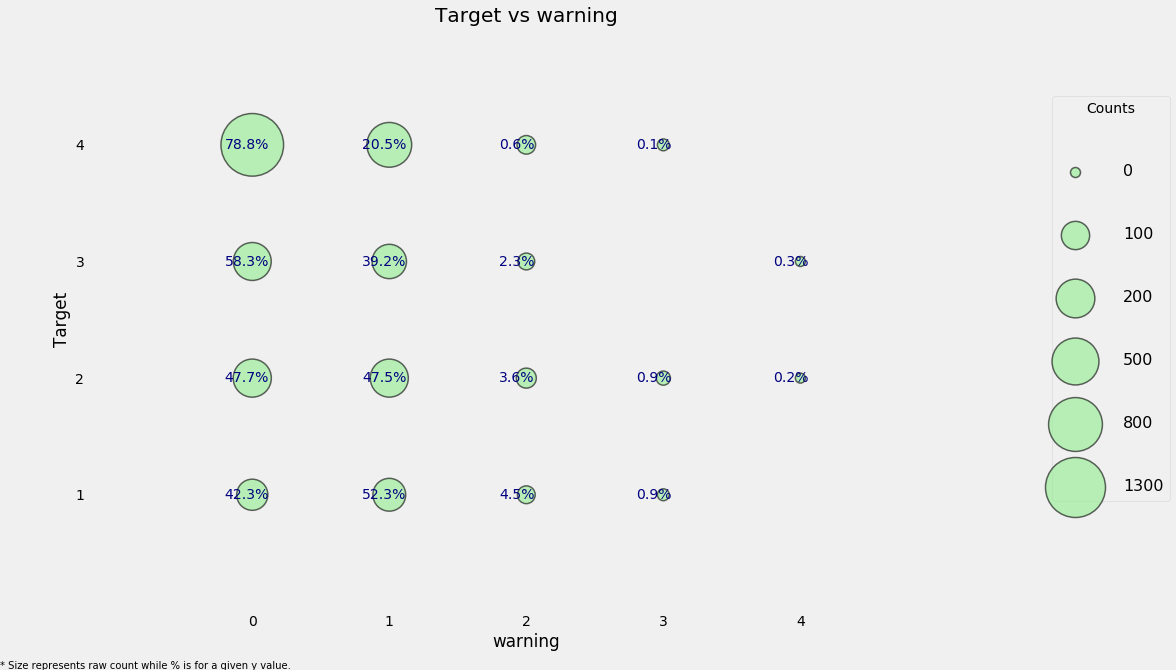

In [79]:
plot_categoricals('warning', 'Target', data = heads)

The violinplot is not great here because it smooths out the categorical variable with the effect that it looks as if the Target can take on lesser and greater values than in reality. Nonetheless, we can see a high concentration of households that have no warning signs and have the lowest level of poverty. It looks as if this may be a useful feature, but we can't know for sure until we get to modeling!

The final household feature we can make for now is a `bonus` where a family gets a point for having a refrigerator, computer, tablet, or television.

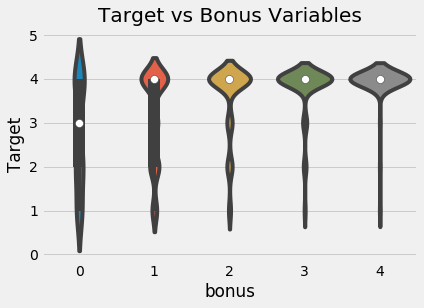

In [80]:
# Owns a refrigetator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])
sns.violinplot('bonus', 'Target', data=heads, figsize=(10, 6))
plt.title('Target vs Bonus Variables');

## Per Capita Features

Additional features we can make calculate the number of certain measurements for each person in the household.

In [81]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## Exploring Household Variables

After going to all the trouble of getting our features in order, now we can take a look at them in relation to the Target. We've already done a little of this, but now we can try to quantify relationships.

### Measuring Relationships

There are many ways for measuring relationships between two variables. Here we will examine two of these:

1. The Pearson Correlation: from -1 to 1 measuring the linear relationship between two variables
2. The Spearman Correlation: from -1 to 1 measuring the monotonic relationship between two variables

The Spearman correlation is 1 if as one variable increases, the other does as well, even if the relationship is not linear. On the other hand, the Pearson correlation can only be one if the increase is exactly linear. These are best illustrated by example.

In [82]:
from scipy.stats import spearmanr

In [83]:
def plot_corrs(x, y):
    """Plot data and show the spearman and pearson correlation"""
    
    # Calculate correlations
    spr = spearmanr(x, y).correlation
    pcr = np.corrcoef(x, y)[0, 1]
    
    # Scatter plot
    data = pd.DataFrame({'x': x, 'y': y})
    plt.figure(figsize=(6,4))
    sns.regplot('x', 'y', data=data, fit_reg=False);
    plt.title(f'Spearman: {round(spr, 2)}; Pearson: {round(pcr, 2)}');

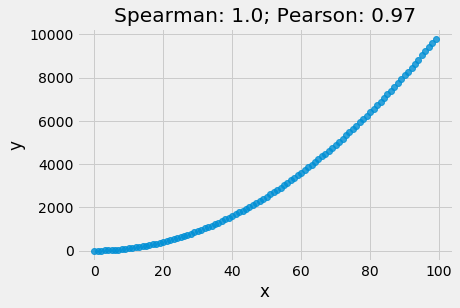

In [84]:
x = np.array(range(100))
y = x ** 2

plot_corrs(x, y);

The Spearman correlation is often considered to be better for ordinal variables such as the Target or the years of education. Most relationshisp in the real world aren't linear, and although the Pearson correlation can be an approximation of how related two variables are, it's inexact and not the best method of comparison.

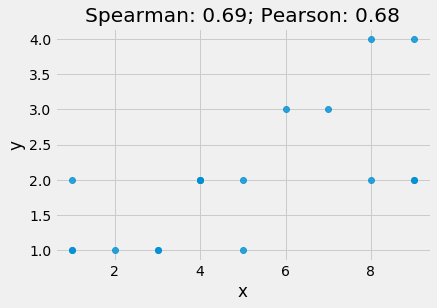

In [85]:
x = np.array([1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9])
y = np.array([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 2, 4, 2, 2, 4])

plot_corrs(x, y)

In most cases, the values are very similar.

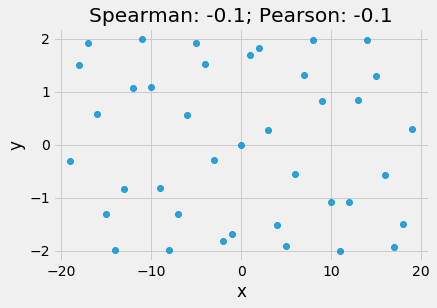

In [86]:
x = np.array(range(-19, 20))
y = 2 * np.sin(x)

plot_corrs(x, y);

First, we'll calculate the Pearson correlation of every variable with the Target.



In [87]:
# Use only training data
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns={'Target': 'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns={'index': 'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('\nMost positively correlated variables:')
print(pcorrs.dropna().tail())

Most negatively correlated variables:
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4          r4m1 -0.209479

Most positively correlated variables:
              feature     pcorr
87  phones-per-capita  0.299026
88              floor  0.307605
89   walls+roof+floor  0.332446
90           meaneduc  0.333652
91             Target  1.000000


In [88]:
train_heads.corr()['Target'].sort_values()

warning            -0.301791
hogar_nin          -0.266309
r4t1               -0.260917
overcrowding       -0.234954
r4m1               -0.209479
                      ...   
floor               0.307605
walls+roof+floor    0.332446
meaneduc            0.333652
Target              1.000000
elimbasu5                NaN
Name: Target, Length: 93, dtype: float64

For the negative correlations, as we increase the variable, the Target decreases indicating the poverty severity increases. Therefore, as the `warning` increases, the poverty level also increases which makes sense because this was meant to show potential bad signs about a house. The `hogar_nin` is the number of children 0 - 19 in the family which also makes sense: younger children can be financial source of stress on a family leading to higher levels of poverty. Or, families with lower socioeconomic status have more children in the hopes that one of them will be able to succeed. Whatever the explanation, there is a [real link between family size and poverty](https://www.adb.org/sites/default/files/publication/157217/adbi-rp68.pdf)

On the other hand, for the positive correlations, a higher value means a higher value of Target indicating the poverty severity decreases. The most highly correlated household level variable is `meaneduc`, the average education level of the adults in the household. This relationship between education and poverty intuitively makes sense: [greater levels of education generally correlate with lower levels of poverty](https://www.childfund.org/poverty-and-education/). ***We don't necessarily know which causes which, but we do know these tend to move in the same direction.***

The general guidelines for correlation values are below, but these will change depending on who you ask ([source](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) for these):

*  .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
*  .80-1.0 “very strong”

What these correlations show is that there are some weak relationships that hopefully our model will be able to use to learn a mapping from the features to the Target.

Now we can move on to the Spearman correlation. 

In [89]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# Iterate through each column
for c in heads:
    # Only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculate spearman correlation
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)

scorrs = pd.DataFrame({'feature': feats, 'scorr': scorr, 'pvalue': pvalues}).sort_values('scorr')

The Spearman correlation coefficient calculation also comes with a `pvalue` indicating the significance level of the relationship. Any `pvalue` less than 0.05 is genearally regarded as significant, although since we are doing multiple comparisons, we want to divide the p-value by the number of comparisons, a process known as the Bonferroni correction. 

In [90]:
print('Most negative Spearman correlations:')
print(scorrs.head())
print('\nMost positive Spearman correlations:')
print(scorrs.dropna().tail())

Most negative Spearman correlations:
        feature     scorr        pvalue
87      warning -0.307326  4.682829e-66
58   dependency -0.281516  2.792620e-55
75    hogar_nin -0.236225  5.567218e-39
70         r4t1 -0.219226  1.112230e-33
8   pisocemento -0.209387  8.270816e-31

Most positive Spearman correlations:
              feature     scorr        pvalue
23          cielorazo  0.300996  2.611808e-63
85              floor  0.309638  4.466091e-67
89  phones-per-capita  0.337377  4.760104e-80
86   walls+roof+floor  0.338791  9.539346e-81
0              Target  1.000000  0.000000e+00


For the most part, the two methods of calculating correlations are in agreement. Just out of curiousity, we can look for the values that are furthest apart.

In [91]:
corrs = pcorrs.merge(scorrs, on = 'feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

,feature,pcorr,scorr,pvalue,diff
69,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119
77,v18q1,0.197493,0.244200,1.282664e-41,-0.046708
79,tablets-per-capita,0.204638,0.248642,3.951568e-43,-0.044004
2,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691
87,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351


In [92]:
corrs.sort_values('diff').dropna().tail()

,feature,pcorr,scorr,pvalue,diff
50,techozinc,0.014357,0.003404,8.528369e-01,0.010954
44,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549
80,edjefe,0.235687,0.214736,2.367521e-32,0.020951
58,edjefa,0.052310,0.005114,7.804715e-01,0.047197
13,dependency,-0.126465,-0.281516,2.792620e-55,0.155051


The largest discrepancy in the correlations is `dependency`. We can make a scatterplot of the `Target` versus the `dependency` to visualize the relationship. We'll add a little jitter to the plot because these are both discrete variables.

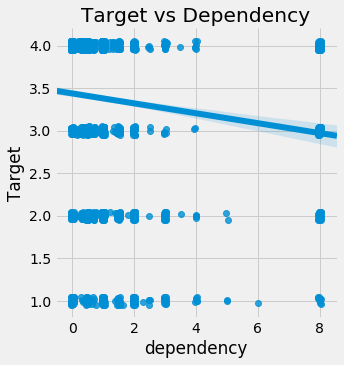

In [95]:
sns.lmplot('dependency', 'Target', fit_reg=True, data=train_heads,
          x_jitter=0.05, y_jitter=0.05)
plt.title('Target vs Dependency');

It's hard to see the relationship, but it's slightly negative: as the `dependency` increases, the value of the `Target` decreases. This makes sense: the `dependency` is the number of dependent individuals divided by the number of non-dependents. As we increase this value, the poverty severty tends to increase: having more dependent family members (who usually are non-working) leads to higher levels of poverty because they must be supported by the non-dependent family members. 

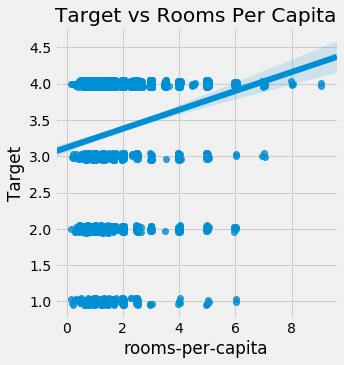

In [96]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg=True, data=train_heads,
          x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Rooms Per Capita');

#### Correlation Heatmap 

One of my favorite plots is the correlation heatmap because it shows a ton of info in one image. For the heatmap, we'll pick 7 variables and show the correlations between themselves and with the target. 

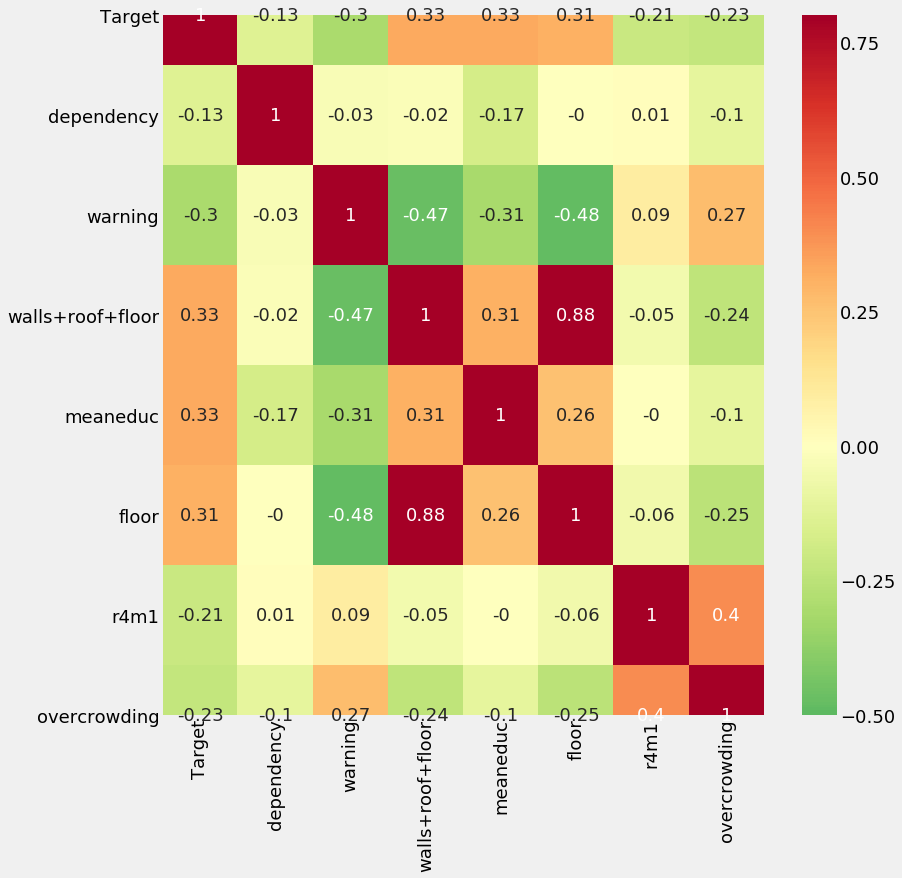

In [97]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc',
             'floor', 'r4m1', 'overcrowding']

# Calculate the correlations
corr_mat = train_heads[variables].corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize=(12,12))
sns.heatmap(corr_mat, vmin=-0.5, vmax=0.8, center=0,
           cmap=plt.cm.RdYlGn_r, annot=True);

This plot shows us that there are a number of variables that have a weak correlation with the `Target`. There are also high correlations between some variables (such as `floor` and `walls+roof+floor`) which could pose an issue because of collinearity. 

### Features Plot

For the final exploration of the household level data, we can make a plot of some of the most correlated variables with the Target. This shows scatterplots on the upper triangle, kernel density estimate (kde) plots on the diagonal, and 2D KDE plots on the lower triangle.

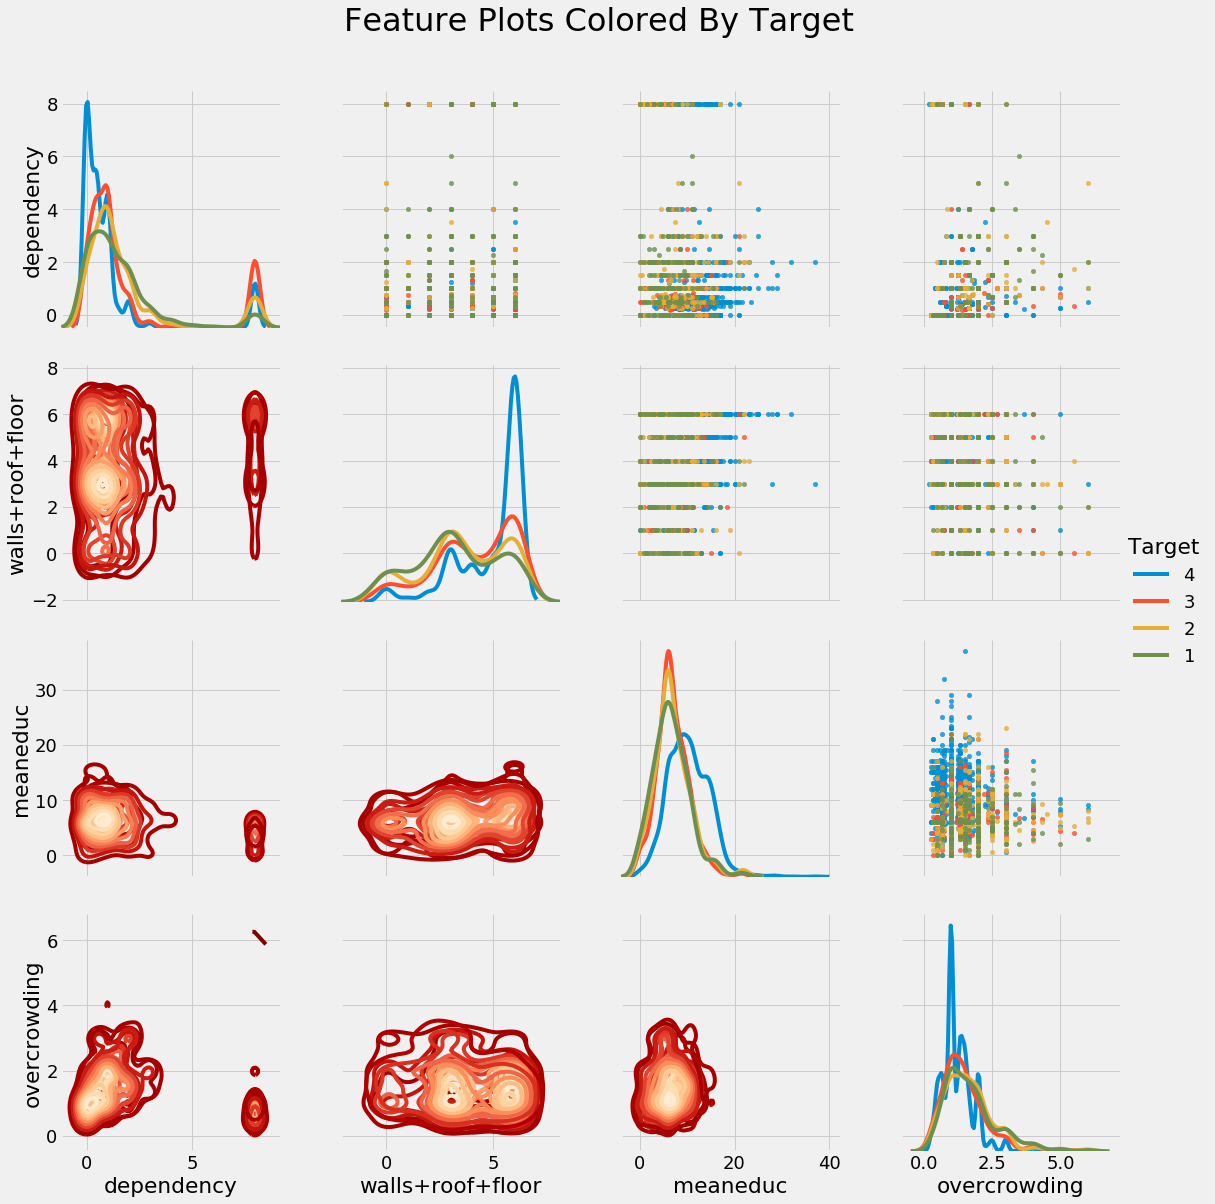

In [99]:
import warnings
warnings.filterwarnings('ignore')

# Copy the data for plotting
plot_data = train_heads[['Target', 'dependency', 'walls+roof+floor',
                        'meaneduc', 'overcrowding']]

# Create the pairgrid object
grid = sns.PairGrid(data=plot_data, size=4, diag_sharey=False,
                   hue='Target', hue_order=[4, 3, 2, 1],
                   vars=[x for x in list(plot_data.columns) if x !='Target'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha=0.8, s=20)

# Diagnoal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r);
grid = grid.add_legend()
plt.suptitle('Feature Plots Colored By Target', size=32, y=1.05);

We'll leave the feature engineering of the household variables for now. Later, we can come back to this step if we are not pleased with the model performance.

In [100]:
household_feats = list(heads.columns)

# Individual Level Variables

There are two types of individual level variables: Boolean (1 or 0 for True or False) and ordinal (discrete values with a meaningful ordering). 

In [101]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

## Redundant Individual Variables

We can do the same process we did with the household level variables to identify any redundant individual variables. We'll focus on any variables that have an absolute magnitude of the correlation coefficient greater than 0.95.